In [13]:
# Import the Earth Engine Python Package
import ee

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

ee.Initialize()

# use matplotlib converters for plotting?
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [14]:
## define python functions

# function to find max value in a dataframe with DateTime column
def find_max(df, index):

    max_value = np.nanmax(df.iloc[:, index])
    
    t_max = df[df.iloc[:, index]  == max_value].DateTime.tolist()[0] 
    
    return max_value, t_max

def water_max_plot(df, name, index, zoom = False):
    
    # calculate max location    
    max_value, t_max = find_max(df, index)
    
    # matplotlib stuff
    plt.figure(num=None, figsize=(16,9), dpi=80, facecolor='w', edgecolor='w')
    ax = plt.subplot(111)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if not zoom:
        ax.set_ylim([0, 200000])
        
    plt.grid(alpha = .2)
    register_matplotlib_converters()

    # plot max lines
    plt.axvline(x = t_max, color = 'black',linestyle = '--', alpha = .5, label = 'highes value')
    plt.axhline(y = max_value, alpha = .5, linestyle = '--', label = 'abs max')

    # plot data and running mean
    plt.plot(df.DateTime,df.size_water, 'bo', alpha = .2, label = 'measurements')
    plt.plot(df.DateTime, df.iloc[:, index], color = 'red', label = 'running mean')

    plt.title(' Total water area over time for: ' + name + ' \n' +\
              ' Time at max value: ' + t_max.strftime("%Y-%m-%d"))

    plt.xlabel('Time')
    plt.ylabel('Area')

    plt.legend()
    plt.show()

In [15]:
## create Google Earth Engine functions

# create buffer function
def buffer1k(feature):
    return feature.buffer(500)

def waterfunction(image):
  
    image2 = image  .reproject(crs ='EPSG:4326', scale = SCALE)\
                      .focal_mode()\
                      .focal_max(3).focal_min(5).focal_max(3)\
                      .reproject(crs ='EPSG:4326', scale = SCALE)
                    
  
    # get pixels above the threshold
    water01 = image2.lt(-12)
    # mask those pixels from the image
    image = image.updateMask(water01)
    #  calculate pixelalreas
    area = ee.Image.pixelArea()
    waterArea = water01.multiply(area).rename('waterArea');
    #   add waterarea band to uitput
    image = image.addBands(waterArea)

    return image

# reducer function for area calculation
def setProperty(image):
    dict = image.reduceRegion(ee.Reducer.sum(), AOI_geometry, maxPixels = 60000000)
    return image.set(dict)



# Get number of pixels for point buffers


In [16]:
# define points of interest

features = [
  ee.Feature(ee.Geometry.Point(106.83471,-6.197928), {'name': 'Situ Lembang'}),           # 0  
  ee.Feature(ee.Geometry.Point(106.80394,-6.211232), {'name': 'Waduk Taman Ria Senayan'}),# 1
  ee.Feature(ee.Geometry.Point(106.82223,-6.349455), {'name': 'Situ Mangga Bolong'}),     # 2
  ee.Feature(ee.Geometry.Point(106.82136,-6.314984), {'name': 'Waduk Ragunan'}),          # 3 
  ee.Feature(ee.Geometry.Point(106.82221,-6.343443), {'name': 'Situ Babakan'}),           # 4
  ee.Feature(ee.Geometry.Point(106.84812,-6.257327), {'name': 'Situ TMP Kalibata'}),      # 5
  ee.Feature(ee.Geometry.Point(106.88793,-6.357405), {'name': 'Situ Rawa Dongkal'}),
  ee.Feature(ee.Geometry.Point(106.92210,-6.211445), {'name': 'Situ Rawa Badung'}), 
  ee.Feature(ee.Geometry.Point(106.91205,-6.202781), {'name': 'Situ Rawa Gelam'}), 
  ee.Feature(ee.Geometry.Point(106.88569,-6.338337), {'name': 'Rawa Babon'}),
  ee.Feature(ee.Geometry.Point(106.89472,-6.304803), {'name': 'Situ Rawa TMII'}),
  ee.Feature(ee.Geometry.Point(106.93248,-6.196898), {'name': 'Situ Rawa Penggilingan'}),
  ee.Feature(ee.Geometry.Point(106.95598,-6.163825), {'name': 'Situ Rawa Rorotan'}),
  ee.Feature(ee.Geometry.Point(107.03692,-6.351368), {'name': 'Rawa Burankeng'})
];

## Read shapefile and load to gee

In [17]:
# current working directory
import os
cwd = os.getcwd()
cwd

'/home/chris/Documents/GreenCityWatch/GCW_toolkit/GEE_GBDX_local'

In [95]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../TreeTect/data/shapefiles_waterbodies_osm/*.shp'
shape_files = glob.glob(shape_file_path)
path = shape_files[1]

shape_files, cwd, path

(['../../TreeTect/data/shapefiles_waterbodies_osm/Denpasar_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Balikpapan_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Medan_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Jakarta_water_areas.shp'],
 '/home/chris/Documents/GreenCityWatch/GCW_toolkit/GEE_GBDX_local',
 '../../TreeTect/data/shapefiles_waterbodies_osm/Balikpapan_water_areas.shp')

In [106]:
shp_AOIs = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 
id_list = [pol['id'] for pol in fiona.open(path)]

features = []

for shp_AOI in shp_AOIs:
    # convert data format to usable format for google earth engine api
    x = shp_AOI.exterior.coords.xy[0]
    y = shp_AOI.exterior.coords.xy[1]
    geometry_list = list(np.column_stack((x, y)).flatten())
    
    features.append(ee.Feature(ee.Geometry.MultiPolygon(geometry_list)))




In [102]:
# upload geometry to the cloud service
features = [
    ee_geometry_list
    
  #ee.Feature(ee.Geometry.MultiPolygon(geometry_list), {'name': id_list[0]})
];

In [103]:
len(shp_AOIs)

40

In [104]:
# print this to use in https://code.earthengine.google.com/ 

# np.column_stack((x, y))

In [107]:
features[0].geometry().getInfo()['type']

'Polygon'

# Collect and plot data

In [108]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

i = 1

no name in feature, get from id_list


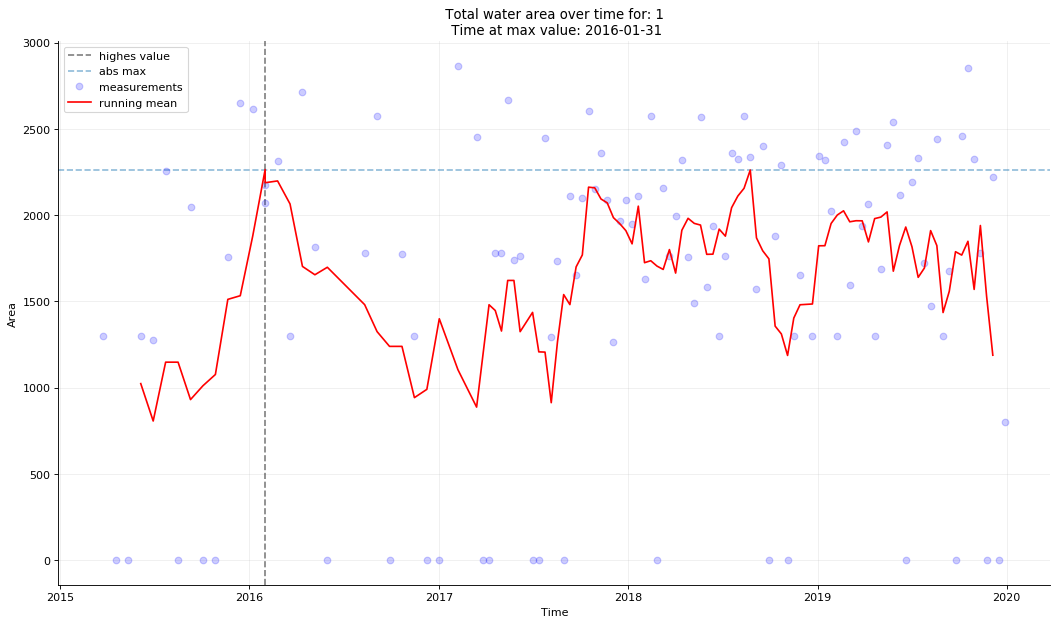

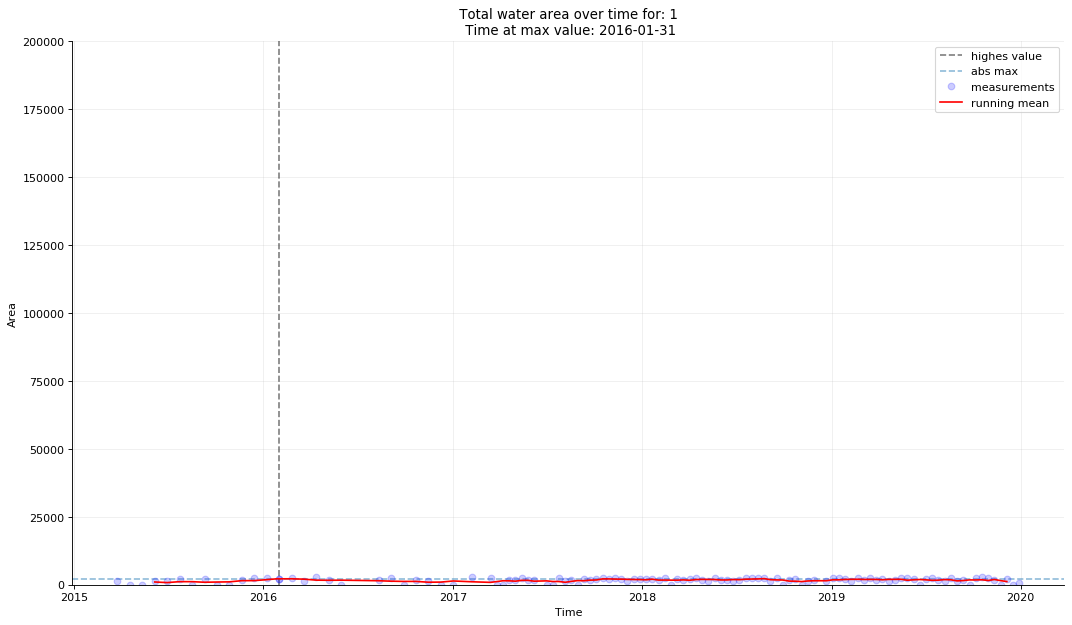

1 2016-01-31 04:49:01.100000


In [113]:
# for i in [4,4]:

# set water body of interest
waterbody_i = i

#set waterthreshol
waterThreshold = -12; 

try:
    name = features[waterbody_i].getInfo()['properties']['name']
except:
    print('no name in feature, get from id_list')
    name = id_list[waterbody_i]

# if point apply buffer to area of interest otherwise use polygon
if features[0].geometry().getInfo()['type'] == 'Point':
    AOI_geometry = ee.FeatureCollection(features[waterbody_i]).map(buffer1k).geometry()
else: 
    AOI_geometry = features[waterbody_i].geometry()


# apply functions to GEE

# Get the SAR data from the Sentinel-1 collection.
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filterDate('2015-01-01', '2019-12-30')\
    .filterBounds(AOI_geometry)\
    .select(['VV']);

collection = S1.map(waterfunction);

withSum = collection.map(setProperty)

# get time 
value_time = withSum.aggregate_array('segmentStartTime').getInfo()

# get data 
value_mask_size = withSum.aggregate_array('waterArea').getInfo()

# convert timestamp to DateTime 2016-02-25 05:33:19.610
time = [datetime.datetime.fromtimestamp(int(float(i))/1000) for i in (value_time)]

### Reshape data into Pandas Dataframe
df = pd.DataFrame(data=value_mask_size, index=list(range(len(value_mask_size))),\
                  columns=['size_water'])

df = df.interpolate()
df['DateTime'] = pd.Series(time, index=df.index)

df = df.sort_values('DateTime').reset_index(drop = True)

# remove outliers
df = df[np.abs(df.size_water-df.size_water.mean()) <= (3*df.size_water.std())]

# add running means
df['roll_mean'] = df['size_water'].rolling(window = 6, center = True).mean()

index = 2

water_max_plot(df, name, index, zoom = True)
water_max_plot(df, name, index, zoom = False)    

max_value, t_max = find_max(df, index)

print(name, t_max)

# GBDX integration

In [114]:
index = 2

In [115]:
max_value, t_max = find_max(df, index)

In [116]:
t_max

Timestamp('2016-01-31 04:49:01.100000')

In [117]:
# current working directory
import os
cwd = os.getcwd()

cwd

'/home/chris/Documents/GreenCityWatch/GCW_toolkit/GEE_GBDX_local'

In [118]:
import csv

from gbdxtools.task import env
from gbdxtools import Interface, CatalogImage
import gbdx_auth

# gbdx_auth = gbdx_auth.get_session('/home/chris/.gbdx-config/credentials')

gbdx = Interface()


%matplotlib inline

In [119]:
from shapely.geometry import shape

### convert ee.geometry to wkt for use in GBDX
# get geometry from ee
AOI_JSON = AOI_geometry.getInfo() 
# convert to shapely shape
geom = shape(AOI_JSON)
# convert to wkt
wkt_string = geom.wkt


In [120]:
type(geom.bounds)

tuple

In [121]:
str_ = ', '.join(map(str, geom.bounds))

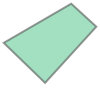

In [122]:
geom

In [123]:
wkt_string

'POLYGON ((116.954923 -1.229685, 116.955317 -1.230066, 116.955805 -1.229531, 116.955566 -1.229312, 116.954923 -1.229685))'

In [124]:
# define filters for GBDX search
filters = [
        "(sensorPlatformName ='WORLDVIEW02' OR sensorPlatformName ='WORLDVIEW03')",
        "cloudCover < 50" # AND coverage > 50"
]

In [125]:
# create search window 
window = 200

search_start = t_max - datetime.timedelta(days = window) 
search_end = t_max + datetime.timedelta(days = window)


str_search_start = search_start.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
str_search_end = search_end.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

print("Start: " + str_search_start + "\nEnd: " + str_search_end)

Start: 2015-07-15T04:49:01.100000Z
End: 2016-08-18T04:49:01.100000Z


## Run search on GBDX

In [126]:
results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                          startDate=str_search_start,
                          endDate=str_search_end,
                          filters=filters)

In [127]:
# check number of results
len(results)

7

In [128]:
for result in results:
    image_id = result['identifier']
    ordered = CatalogImage.is_ordered(image_id)
    print(image_id, ordered)
    

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/gbdxtools/images/catalog_image.py:75: UserWarning: is_ordered() is deprecated, use CatalogImage.is_available() instead
  warnings.warn('is_ordered() is deprecated, use CatalogImage.is_available() instead')


1030010057581100 False
103001005B918500 False
1030010049143000 False
103001004A655F00 False
103001004C82D400 False
1030010047330600 False
103001004D0F6D00 True


In [129]:
image_id = results[6]['identifier']
catalog_id = env.inputs.get('catalog_id', image_id)
catalog_id

'103001004D0F6D00'

In [130]:

bbox = env.inputs.get('bbox', ', '.join(map(str, geom.bounds)))

bbox = env.inputs.get('bbox', bbox)


In [131]:
## Get image from GBDX

# order if not ordered
# otherwise print error and check

try:
    print("Try to get image from GBDX...")
    image = CatalogImage(image_id, bbox=map(float, bbox.split(",")))
    
    print("Success")
except:
    
    print("Check if image is ordered... ")
    
    ordered = CatalogImage.is_ordered(image_id)
    
    if not ordered:
        order_id = gbdx.ordering.order(image_id)
        
 
        with open('order_id_{}.csv'.format(image_id), newline='') as File:  
            reader = csv.reader(File)
            for row in reader:
                print(row)
                
        print("Image {} ordered with order id: {}".format(image_id, order_id))
                
    else:
        print("Image ordered is: {}".format(ordered))


        print('Image error')

Try to get image from GBDX...
Success


In [132]:
# Get timestamp
time_image = image.metadata["image"]["acquisitionDate"] 

# convert timestamp to datetime timestamp format
time_image = datetime.datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")

time_image

datetime.datetime(2015, 11, 10, 2, 36, 20, 174000)

World View image taken on 2015-11-10T02:36:20.174Z
Time difference between highes water and image is:  -83 days +21:47:19.074000


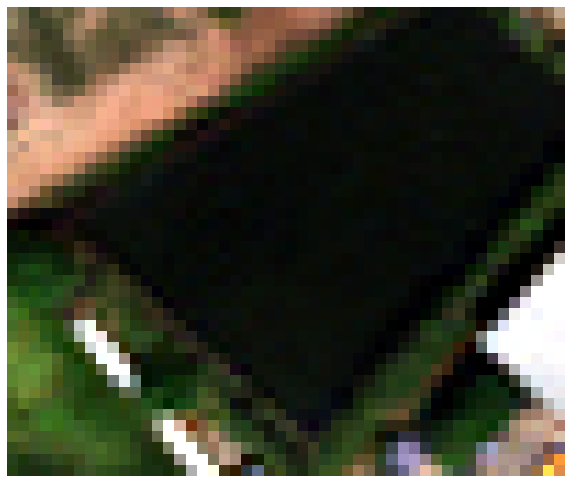

In [133]:
print("World View image taken on {}".format( image.metadata["image"]["acquisitionDate"]))
print('Time difference between highes water and image is: ', time_image - t_max)

image.plot(w=10, h=10)

# Transform dask array to array
image_array = image.read()
data = image_array

# plot cleaning steps

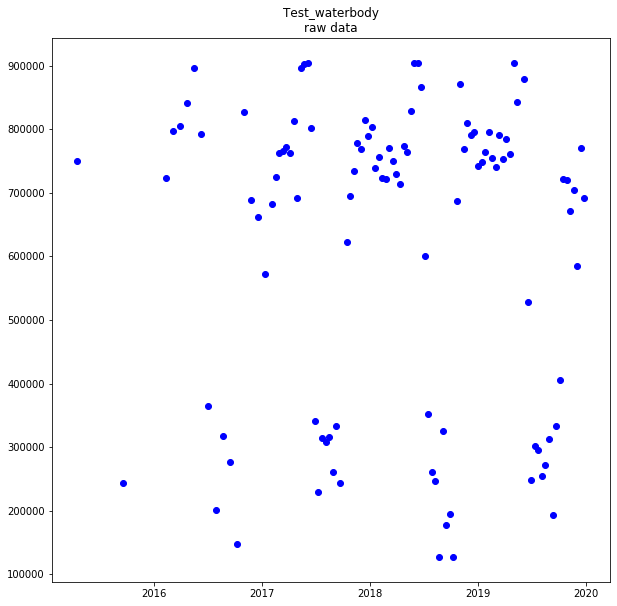

In [15]:
# and visually
plt.figure(figsize= (10,10))
plt.plot(df.DateTime,df.size_water, 'bo')
plt.title(name + '\nraw data')
plt.show()

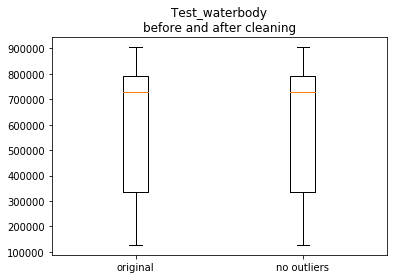

In [16]:
plt.boxplot([value_mask_size, df.size_water], labels=['original', 'no outliers'])
plt.title(name + '\nbefore and after cleaning')
plt.show()

# Get polygon?

In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '103001009A066100')
bbox = env.inputs.get('bbox', '106.94986581802368, -6.173472986688516, 106.9567108154297, -6.163147599856556')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

In [65]:
# set water body of interest
waterbody_i = 4

#set waterthreshol
waterThreshold = -13; 

name = features[waterbody_i].getInfo()['properties']['name']

# apply buffer to area of interest
AOI_geometry = ee.FeatureCollection(features[waterbody_i]).map(buffer1k).geometry()


# apply functions to GEE


def waterfunction2(image):
  
    image2 = image  .reproject(crs ='EPSG:4326', scale = SCALE)\
                      .focal_mode()\
                      .focal_max(1).focal_min(1).focal_max(2)\
                      .reproject(crs ='EPSG:4326', scale = SCALE)
  
    # get pixels above the threshold
    water01 = image2.lt(-13)
    # mask those pixels from the image
    image = image.updateMask(water01)
    #  calculate pixelalreas
    area = ee.Image.pixelArea()
    waterArea = water01.multiply(area).rename('waterArea').toInt();
    #   add waterarea band to uitput
    image = image.addBands(waterArea)

    return image


# Get the SAR data from the Sentinel-1 collection.
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filterDate('2015-01-01', '2019-12-30')\
    .filterBounds(AOI_geometry)\
    .select(['VV']);

collection = S1.map(waterfunction2);



# im = ee.Image(collection.first())

In [68]:



# build geometry to measure
rect = ee.Geometry.Polygon(
        [[[106.81355510309686,-6.353704992127306],
        [106.82745967463006,-6.353704992127306],
        [106.82745967463006,-6.337667686800708],
        [106.81355510309686,-6.337667686800708],
        [106.81355510309686,-6.353704992127306]]])

# convert geometry to JSON format
rect_JSON = rect.getInfo()['coordinates']



im2 = collection.first().select('waterArea').clip(rect).reduceToVectors();

In [70]:
water_FeatureCollection = im2.getInfo()

In [75]:
water_FeatureCollection['features'][0]

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Polygon',
  'coordinates': [[[106.81381953211806, -6.353424678463727],
    [106.81390936364646, -6.353424678463727],
    [106.81390936364646, -6.353245015406904],
    [106.81381953211806, -6.353245015406904],
    [106.81381953211806, -6.353424678463727]]]},
 'id': '+1189046+70725',
 'properties': {'count': 2, 'label': 98}}

In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '10300100996F7F00')
bbox = env.inputs.get('bbox', '106.89491271972658, -6.123145498606175, 106.95945739746095, -6.0794491137500195')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

0  :  2
1  :  3
2  :  4
3  :  2
4  :  4
5  :  28
6  :  4
7  :  12
8  :  10
9  :  3
10  :  1174
11  :  76
12  :  1
13  :  1
14  :  297
15  :  2
16  :  3
17  :  25964


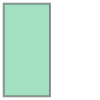

In [80]:
from shapely.geometry import shape

i = 0

for feature in water_FeatureCollection['features']:
    
    print(i, ' : ', feature['properties']['count'])
    
    i += 1



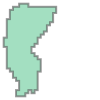

In [85]:
shape(water_FeatureCollection['features'][14]['geometry'])

In [42]:
# visualize resulting image
url=collection.first().getThumbUrl({
    'region':rect_JSON,
#     'min':-25,
#     'max':0,
#     'palette':['0784b5', '39ace7']
})

Image(url=url)

In [83]:
import folium

In [84]:
bbox_list_str = bbox.split(',')
bbox = [float(bbox_list_str[0]),float(bbox_list_str[1]),float(bbox_list_str[2]),float(bbox_list_str[3])]


NameError: name 'bbox' is not defined

In [ ]:
m = folium.Map([(bbox[1] + bbox[3])/2, (bbox[0] + bbox[2])/2],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB', name = 'cartocdn')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


folium.Choropleth(setu_wgs, name = 'Setu water delineation').add_to(m)

folium.Choropleth(setu_smooth, name = 'Smooth setu delineation').add_to(m)

folium.Choropleth(setu_poly, name = 'setu poly').add_to(m)

# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=df['ActualDBH'][point], group  = "Tree removals").add_to(m)

folium.LayerControl().add_to(m)

In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1030010085B5FC00')
bbox = env.inputs.get('bbox', '106.89491271972658, -6.123145498606175, 106.95945739746095, -6.0794491137500195')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '103001009A066100')
bbox = env.inputs.get('bbox', '106.89491271972658, -6.123145498606175, 106.95945739746095, -6.0794491137500195')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)